In [3]:
# imports
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# set random generator
generator = np.random.RandomState(42)

# settings of graphics
width = 17
height = 5
matplotlib.rcParams['figure.figsize'] = [width, height]
matplotlib.rcParams['lines.markersize'] = 0.5
matplotlib.rcParams['scatter.edgecolors'] = "black"

# autoregression generator
def ar(p, arr, noise_maker, to_add = 10000):
    new_vals = np.array(arr)
    new_vals = np.append(new_vals, [0] * to_add)
    pos = 1
    for i in range(to_add):
        noise = noise_maker(i)
        new_vals[pos + i] = p * new_vals[pos + i - 1] + noise
    return new_vals

# fourier transform
def mfft(a, draw=False):
    plt.rcParams['axes.grid'] = True
    plt.tight_layout()
    A = np.fft.rfft(a)
    N = len(a)
    if (draw):
        plt.rcParams['axes.grid'] = True
        fig, ax = plt.subplots(2, figsize=(6,4), dpi=150)
        plt.tight_layout()
        n = np.arange(len(a))
        
        ax[0].plot(n, a, '.-')
        ax[0].set_title('$a[n]$')
        ax[1].set_xlim(0, 170)
        ax[1].set_title('$A$')
        ax[1].plot(n[0 : (N // 2 + 1)], np.abs(A), '-')
        
    return np.abs(A)

### Изучаение зависимости амплитуды от параметра p авторегресии
Построим график зависимости  $y = A(p)$. Амплитуду будем определять как максимум массива, возвращаемого функцией ```mfft```. Пока что ограничимся зависимостью шума лишь от одной частоты $w$.

In [4]:
def get_amplitude(p, w=0.1):
    # fixed parameters
    # w - current frequency of the noise, default value is 0.1
    n_points = 1400 # number of points to analyze in FFT
    # generate sequence
    noiser = lambda t: np.sin(w * t)
    data = ar(p, generator.normal(2, 0.2), noiser, n_points)
    # calculate FFT and return major amplitude
    return max(mfft(data, False))

In [5]:
def draw_dependency(w=0.1):
    plt.rcParams['axes.grid'] = True
    plt.rcParams['figure.figsize'] = (12, 5)
    ps = np.linspace(0, 1, 300)
    res = [get_amplitude(p, w) for p in ps]
    plt.plot(ps, res)
    plt.title('Amplitude(p), freq = 0.1')
    plt.xlabel('p')
    plt.ylabel('Abs(Amplitude)')
    plt.gca().set(ylim=(0,10000))
    plt.show()

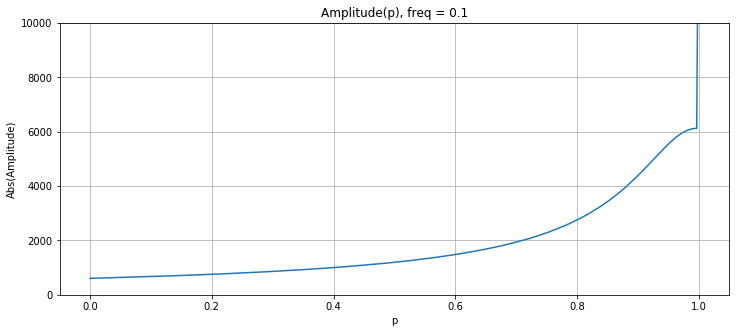

In [21]:
draw_dependency()

### Эксперимент с другими частотами
Попробуем подставить в шум другие частоты и посмотреть, будет ли сильно меняться график.

В функцию передаетя количество частот, графики для которых будем отображать. Для выбора частот ограничимся диапазоном от $\dfrac{2\pi}{200}$ до $\dfrac{2\pi}{100}$. Таким частотам соответствуют периоды от $T = 100$ до $T = 7$. Как видно из графика, на таком диапазоне

In [14]:
def several_frequencies(t_max=317, t_min=200, n_freq=5):
    # n_freq - number of frequences that we want to observe
    fig, ax = plt.subplots(figsize=(10,5))
    
    n_points = 1400 # number of points to analyze in FFT
    ps = np.linspace(0, 1, 300)
    # generate sequence
    freqs = np.linspace(2 * np.pi / t_max, 2 * np.pi / t_min, n_freq)
    all_data = np.array([[]])
    for w in freqs:
        data = np.array([get_amplitude(p, w) for p in ps])
        #if all_data.shape == (1, 0):
        #    all_data = data
        #else:
        #    all_data = np.concatenate((all_data, data))    
        ax.plot(ps, data, label=w)
    #ax.plot(ps, all_data, labels=freqs)
    ax.legend(loc='upper left', title='frequence')
    ax.set_ylim(0, 20000)
    ax.set_xlabel('p')
    ax.set_ylabel('Amplitude')
    ax.set_title('Explore frequencies')

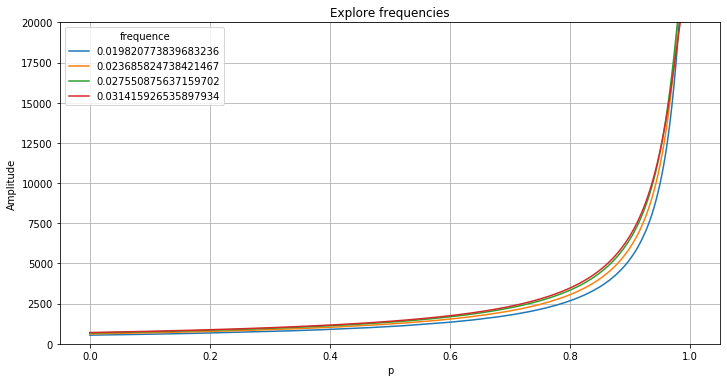

In [15]:
several_frequencies(n_freq=4)

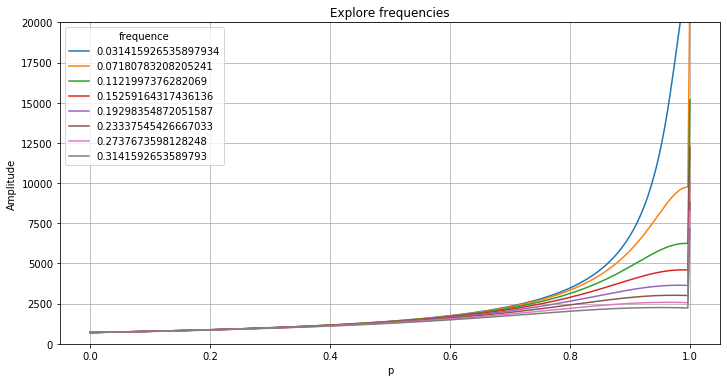

In [16]:
several_frequencies(t_max=200, t_min=20, n_freq=8)

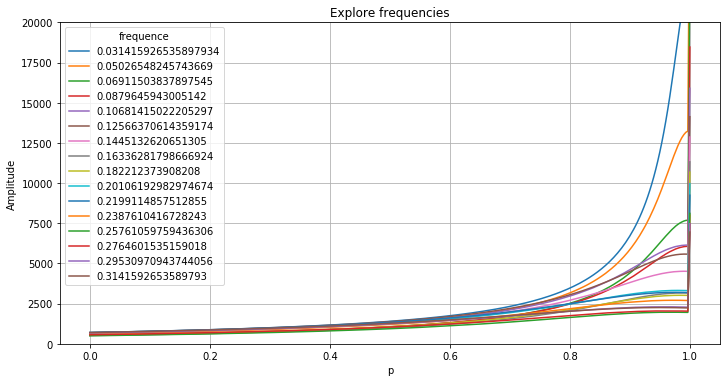

In [19]:
several_frequencies(t_max=200, t_min=20, n_freq=16)

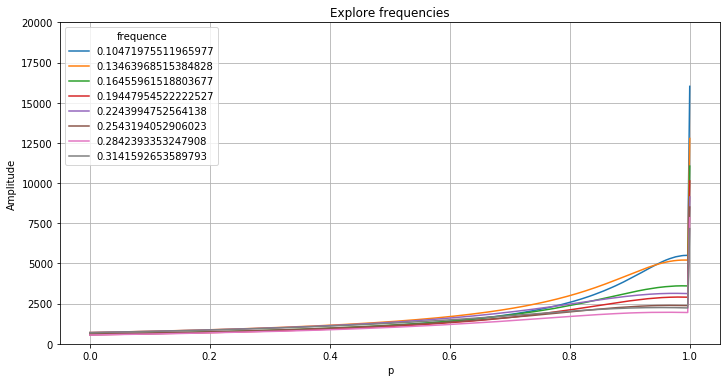

In [17]:
several_frequencies(t_max=60, t_min=20, n_freq=8)

В целом видна следующая закономерность: чем больше частота, тем ближе график к оси $p$. Ожидаемо - чем больше амплитуда, тем меньше частота. Характер графика с изменением частоты не меняется, за исключением его выпуклости вблизи единицы. Для меньших частот характерна выпуклость вниз

### Аппроксимация различными функциями

Вернемся к изучению зависимости $A(p)$. Будем пока рассматривать одну частоту $w = \dfrac{2\pi}{100} \approx 0.0628$. Будем поступать следующим образом: будем исследовать поточечное отношение функции-кандидата к $A(p)$.

In [139]:
def compare_functions(ps, As, f, fname):
    Fs = [f(p) for p in ps]
    fig, ax = plt.subplots(3, 1, figsize=(12, 12))
    ax[0].plot(ps, As, label='A(p)')
    print(Fs[:10])
    ax[0].plot(ps, Fs, label=fname)
    ax[0].legend(prop={'size': 16})
    ax[0].set_xlabel('p')
    ax[0].set_ylabel('Amp(p),F(p)')
    ax[0].set_ylim(0, 40000)
    ax[0].set_title('Both functions')
    n = len(ps)
    R = []
    for i in range(n):
        if Fs[i] == 0:
            R.append(0)
        else:
            R.append(As[i]/Fs[i])
    ax[1].plot(ps, R, label='Amp/F')
    
    ax[1].set_xlabel('p')
    ax[1].set_ylabel('Amp/F')
    ax[1].set_title('Relation')
    ax[1].legend(prop={'size': 16})
    ax[2].plot(np.log10(Fs), As)
    ax[2].set_xlabel('log_10 F(p)')
    ax[2].set_ylabel('A(p)')
    plt.show()

In [70]:
ps = np.linspace(0.01, 1-0.01, 300)
w = np.pi/100
data = [get_amplitude(p, w) for p in ps]

<Figure size 432x288 with 0 Axes>

* $y = \dfrac{1000}{1-x}$

[1.0101010101010102, 1.0134562586855573, 1.0168338717905119, 1.0202340737707716, 1.0236570919921941, 1.0271031568822782, 1.0305725019818701, 1.034065363997925, 1.0375819828573412, 1.0411226017618997]


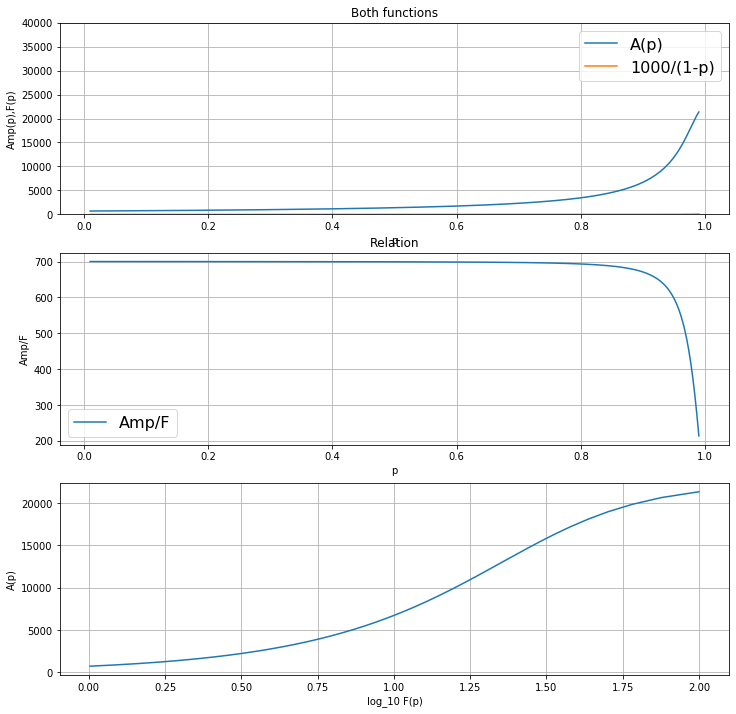

In [140]:
# f = 1000/(1-x)
f1 = lambda x: 1/(1-x)
compare_functions(ps, data, f1, '1000/(1-p)')

* $y = -\dfrac{1000}{\ln x}$

[217.14724095162595, 231.39163089577795, 243.8396356396565, 255.07475299856776, 265.4298389559512, 275.1147102899097, 284.27110005596853, 292.9997566242761, 301.3751586611054, 309.4541067445658]


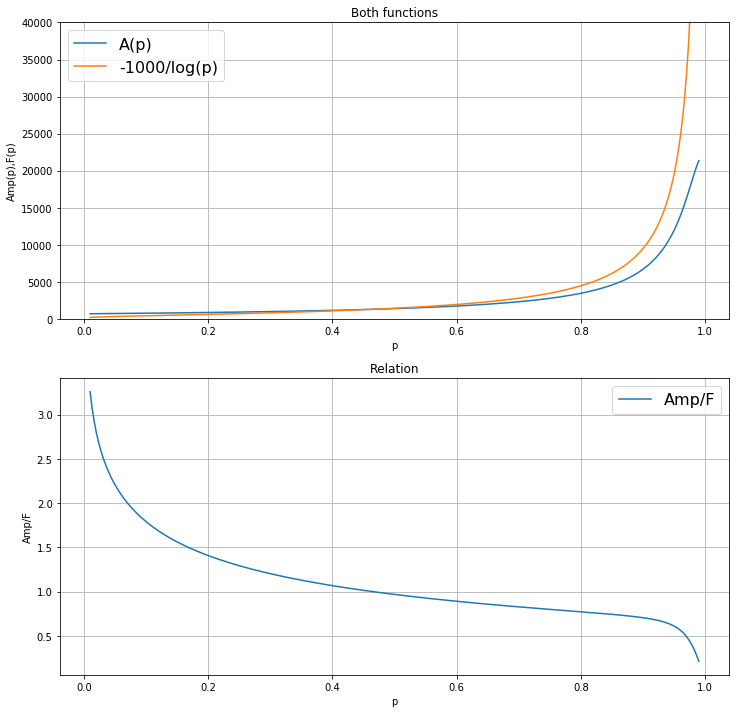

In [122]:
f2 = lambda x: -1000/np.log(x)
compare_functions(ps, data, f2, '-1000/log(p)')